In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import os
import pandas as pd
import shutil

# === Load original grading CSV ===
original_csv = "/content/drive/MyDrive/EECE 490 Project/IDRD/b. IDRiD_Disease Grading_Testing Labels.csv"
df = pd.read_csv(original_csv)

# === Generate new filenames ===
new_ids = [f"IDRid_{i:03d}" for i in range(414, 414 + len(df))]
df["filename"] = new_ids

# === Save updated Excel ===
output_csv = "/content/drive/MyDrive/EECE 490 Project/IDRD/updated_test.csv"
os.makedirs(os.path.dirname(output_csv), exist_ok=True)
df.to_csv(output_csv, index=False)
print("✅ New CSV saved:", output_csv)

# === Paths for images ===
original_img_folder = "/content/drive/MyDrive/EECE 490 Project/IDRD/1. Original Images/b. Testing Set"
new_img_folder = "/content/drive/MyDrive/EECE 490 Project/IDRD/1. Original Images/Testing_updated"
os.makedirs(new_img_folder, exist_ok=True)

# === List of old filenames in order ===
old_filenames = sorted(os.listdir(original_img_folder))
old_filenames = [f for f in old_filenames if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
old_filenames = sorted(old_filenames)[:len(new_ids)]  # Make sure we only map the correct count

# === Rename and copy preserving order ===
for old_name, new_id in zip(old_filenames, new_ids):
    ext = os.path.splitext(old_name)[1]  # Keep original extension
    new_name = new_id + ext
    src = os.path.join(original_img_folder, old_name)
    dst = os.path.join(new_img_folder, new_name)
    shutil.copy2(src, dst)

print(f"✅ {len(new_ids)} images renamed & copied to:", new_img_folder)


✅ New CSV saved: /content/drive/MyDrive/EECE 490 Project/IDRD/updated_test.csv
✅ 103 images renamed & copied to: /content/drive/MyDrive/EECE 490 Project/IDRD/1. Original Images/Testing_updated


In [20]:
import os
import shutil
import pandas as pd

# === Image Folders ===
folder1 = "/content/drive/MyDrive/EECE 490 Project/IDRD/1. Original Images/Testing_updated"
folder2 = "/content/drive/MyDrive/EECE 490 Project/IDRD/1. Original Images/a. Training Set"
combined_folder = "/content/drive/MyDrive/EECE 490 Project/IDRD/1. Original Images/Combined"
os.makedirs(combined_folder, exist_ok=True)

# === Copy and Rename Images to .jpej ===
for folder in [folder1, folder2]:
    for fname in os.listdir(folder):
        if fname.lower().endswith(".jpg"):
            name_no_ext = os.path.splitext(fname)[0]
            new_name = name_no_ext + ".jpeg"
            src = os.path.join(folder, fname)
            dst = os.path.join(combined_folder, new_name)
            shutil.copy2(src, dst)

print("✅ All images copied and renamed to .jpeg!")

# === Excel Paths ===
train_excel = "/content/drive/MyDrive/EECE 490 Project/IDRD/a. IDRiD_Disease Grading_Training Labels.xlsx"
test_excel = "/content/drive/MyDrive/EECE 490 Project/IDRD/updated_test.xlsx"

# === Load Excel Files as-is ===
df_train = pd.read_excel(train_excel)
df_test = pd.read_excel(test_excel)

# === Merge without modifying columns ===
combined_df = pd.concat([df_train, df_test], ignore_index=True)

# === Save merged Excel ===
out_path = "/content/drive/MyDrive/EECE 490 Project/IDRD/combined_labels.xlsx"
combined_df.to_excel(out_path, index=False)

print("✅ Excel (all 3 columns) combined and saved to:", out_path)


✅ All images copied and renamed to .jpeg!
✅ Excel (all 3 columns) combined and saved to: /content/drive/MyDrive/EECE 490 Project/IDRD/combined_labels.xlsx


100%|██████████| 516/516 [05:28<00:00,  1.57it/s]


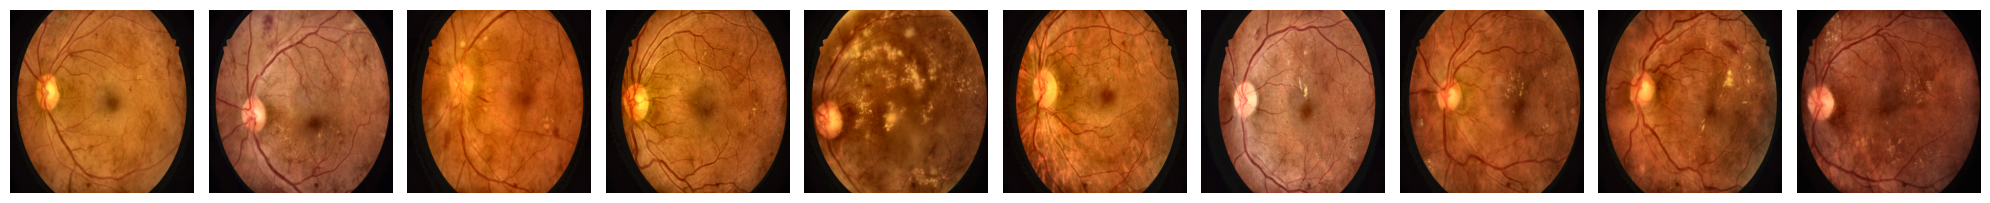


✅ Done! Preprocessed images saved to: /content/drive/MyDrive/EECE 490 Project/IDRD/Cleaned_IDRiD | Skipped 128 bad images.


In [21]:
# === Imports ===
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import shutil

# === Black Border Remover ===
def remove_black_border(img, threshold=5):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img
    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    return img[y:y+h, x:x+w]

# === Auto Flip if Left Eye ===
def auto_flip_if_left_eye(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    left = np.mean(gray[:, :w//2])
    right = np.mean(gray[:, w//2:])
    if right > left:
        return cv2.flip(img, 1)  # horizontal flip
    return img

# === Full Preprocessing Pipeline (Resizing moved to end) ===
def preprocess_image_full(img, target_size=(512, 512), blur_thresh=20.0, brightness_thresh=25):
    try:
        if img is None or len(img.shape) != 3 or img.shape[2] != 3:
            return None

        # Blur and brightness checks
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if cv2.Laplacian(gray, cv2.CV_64F).var() < blur_thresh:
            return None
        if np.mean(gray) < brightness_thresh:
            return None

        # Remove black borders
        img = remove_black_border(img)

        # Auto flip if left eye
        img = auto_flip_if_left_eye(img)

        # CLAHE enhancement
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        img = cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2BGR)

        # Glare detection
        glare_mask = cv2.inRange(img, (240, 240, 240), (255, 255, 255))
        contours, _ = cv2.findContours(glare_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if any(cv2.contourArea(c) > 500 for c in contours):
            return None

        # Text/annotation filter
        mask_text = cv2.inRange(img, (220, 220, 220), (255, 255, 255))
        if cv2.countNonZero(mask_text) > 3000:
            return None

        # Dark region filter
        if np.mean(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) > 10) < 0.2:
            return None

        # ✅ Resize (critical fix)
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

        # ✅ Validate shape before return
        if img.shape != (512, 512, 3):
            raise ValueError(f"Resized image has invalid shape: {img.shape}")

        # Normalize to [-1, 1]
        return img.astype(np.float32) / 127.5 - 1.0

    except Exception as e:
        print(f"⚠️ Exception during processing: {e}")
        return None

# === Set Input/Output Folders ===
input_folder = "/content/drive/MyDrive/EECE 490 Project/IDRD/1. Original Images/Combined"
output_folder = "/content/drive/MyDrive/EECE 490 Project/IDRD/Cleaned_IDRiD"
os.makedirs(output_folder, exist_ok=True)

# === Run Preprocessing ===
skipped = []
image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.jpeg'))]
sample_images = []

for fname in tqdm(image_files):
    in_path = os.path.join(input_folder, fname)
    out_path = os.path.join(output_folder, fname)

    img = cv2.imread(in_path)
    if img is None:
        skipped.append(fname)
        continue

    processed = preprocess_image_full(img)
    if processed is None:
        skipped.append(fname)
        continue
    if processed.shape != (512, 512, 3):
        print(f"⚠️ Unexpected size in {fname}: {processed.shape}")
        skipped.append(fname)
        continue

    out_img = ((processed + 1.0) * 127.5).astype(np.uint8)
    cv2.imwrite(out_path, out_img)

    if len(sample_images) < 10 and random.random() < 0.1:
        sample_images.append(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))

# === Show Random Previews ===
if sample_images:
    plt.figure(figsize=(20, 5))
    for i, img in enumerate(sample_images):
        plt.subplot(1, len(sample_images), i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No sample images to display.")

print(f"\n✅ Done! Preprocessed images saved to: {output_folder} | Skipped {len(skipped)} bad images.")


In [22]:
import os
import cv2

# === Folder containing images ===
folder_path = "/content/drive/MyDrive/EECE 490 Project/IDRD/Cleaned_IDRiD"

# === Loop through all files and check dimensions ===
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)

        if img is None:
            print(f"❌ Could not read {filename}")
            continue

        h, w = img.shape[:2]
        if h != 512 or w != 512:
            print(f"⚠️ {filename} has size {w}x{h}")


In [23]:
cleaned_images = [f for f in os.listdir(output_folder) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
print(f"🧼 Number of cleaned images: {len(cleaned_images)}")


🧼 Number of cleaned images: 388


In [26]:
import os
import pandas as pd

# === Load the combined Excel file ===
df = pd.read_excel("/content/drive/MyDrive/EECE 490 Project/IDRD/combined_labels.xlsx")

# === Force all filenames to end in .jpeg ===
df['filename'] = df['filename'].astype(str).apply(lambda x: os.path.splitext(x)[0] + ".jpeg")

# === Path where your .jpej images are stored ===
output_folder = "/content/drive/MyDrive/EECE 490 Project/IDRD/Cleaned_IDRiD"
kept_images = set(os.listdir(output_folder))

# === Filter the dataframe by available image files ===
df_filtered = df[df['filename'].isin(kept_images)]

# === Count and display label distribution ===
label_counts = df_filtered['diagnosis'].value_counts().sort_index()
for i in range(5):
    print(f"  DR ({i}): {label_counts.get(i, 0)}")

# === Save the filtered DataFrame to a new Excel file ===
output_excel_path = "/content/drive/MyDrive/EECE 490 Project/IDRD/cleaned_labels.xlsx"
df_filtered.to_excel(output_excel_path, index=False)

print(f"\n✅ Filtered Excel file saved to: {output_excel_path}")


  DR (0): 131
  DR (1): 22
  DR (2): 114
  DR (3): 73
  DR (4): 48

✅ Filtered Excel file saved to: /content/drive/MyDrive/EECE 490 Project/IDRD/cleaned_labels.xlsx
